In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import random
from feret_utils import get_feret_files_and_tags_dict, run_face_detection, create_dataset, create_dataset_gs
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plot
from IPython.display import Image
import cv2 as cv
import tensorflow as tf
import scipy
from datetime import datetime
import pickle
tfe = tf.contrib.eager

In [2]:
# Set tf basic settings
print(tf.__version__)
tf.logging.set_verbosity(tf.logging.INFO)
tf.enable_eager_execution()

1.10.0


In [3]:
import pickle
# Unpickle data_dict holding the training and evaluation examples after performing data augmentation and regulerization
with open('feret_data_dict_gs.pickle', 'rb') as handle:
    subject_list, data_dict, mean_image, std_image = pickle.load(handle)

# Dataset sizes and a few examples

(6931, 96, 96, 1)
(6931,)
(268, 96, 96, 1)
(268,)
ID: 0


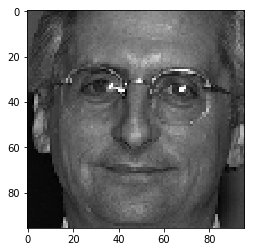

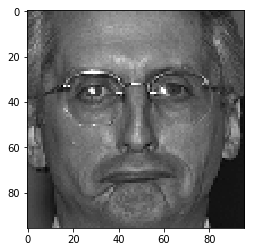

ID: 2


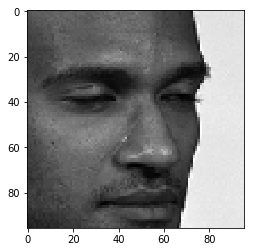

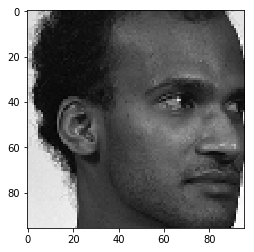

ID: 38


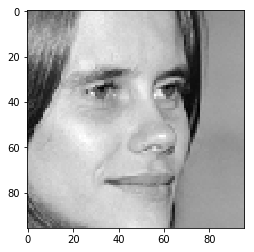

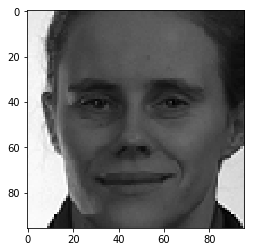

In [4]:
# Show the sizes of the datasets and a few examples of the images in it
print(data_dict['X_train'].shape)
print(data_dict['y_train'].shape)
print(data_dict['X_eval'].shape)
print(data_dict['y_eval'].shape)

for x in [1,43,501]:
    print("ID: {}".format(int(data_dict['y_train'][x])))
    for i in range(2):
        pic = data_dict['X_train'][x+i]
        pic = pic * std_image + mean_image
        pic = pic.reshape(96,96)
        imshow(pic, cmap='gray')
        plot.show()

# Class to manage dataset minibatch structures

In [5]:
class Dataset():
    def __init__(self, X_train, y_train, batch_size=100, num_of_epochs=10):
        self.batch_size = batch_size - (batch_size % 2)
        self.num_of_epochs = num_of_epochs
        self.X_train = X_train
        self.y_train = y_train
        self.unused_y = list(range(len(y_train)))
        self.steps = int((X_train.shape[0] * self.num_of_epochs) / self.batch_size)
    
    def create_mini_batch(self):
        mini_X_train = np.zeros((self.batch_size, 96, 96, 1), dtype=np.float32)
        mini_y_train = np.zeros((self.batch_size))
        if len(self.unused_y) < self.batch_size:
            self.unused_y = list(range(len(self.y_train)))
        half_batch = int(self.batch_size/2)
        for i in range(half_batch):
            pos = random.choice(self.unused_y)
            mini_X_train[i] = self.X_train[pos]
            mini_y_train[i] = self.y_train[pos]
            mini_X_train[i + half_batch] = self.X_train[(pos + 5) % len(self.unused_y)]
            mini_y_train[i + half_batch] = self.y_train[(pos + 5) % len(self.unused_y)]
            self.unused_y.remove(pos)
        
        return mini_X_train, mini_y_train

# Classifier model working with 2 steps of training, classification and comparison. The model will then be used to extract a feature layer which will be compared with other layers.

### The 2 phases of training are comprised of the following losses:
1. Classification loss: standard softmax loss choosing out of 700 classes
2. Image comparison loss: a loss measuring the L2 distance between the feature extraction layer of 2 images and socring according to the following:

    if image_A[id] == image_B[id]:
        loss =+ L2 distance between feature layers of image_A and image_B
    else (both faces are of different people):
        loss =+ min(0, similarity_threshold - L2 distance between feature layers of image_A and image_B)
        *similarity threshold is a parameter which can be changed

In [6]:
# Create a classifier model which uses the data dict to create a 2 phase train
# A. Image classification
# B. Images comparison
class CombinedClassifier(tf.keras.Model):
    def __init__(self, num_of_ids, loss_type="Class", similarity_threshold=5, class_loss=0.5*1e-4):
        super().__init__()
        self.loss_type = loss_type
        self.similarity_threshold = similarity_threshold
        self.num_of_ids = num_of_ids
        self.flag_for_combined_loss = False
        
        # Conv layer 1 + Pooling
        self.conv1a = tf.keras.layers.Conv2D(filters=32,
                                            kernel_size=[4, 4],
                                            strides=(1, 1),
                                            padding='same',
                                            activation=tf.nn.leaky_relu,
                                            use_bias=True,
                                            kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                           )
        
        self.pool1a = tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                               strides=(2, 2),
                                               padding='valid'
                                              )
        
        # Conv layer 2 + Pooling
        self.conv2a = tf.keras.layers.Conv2D(filters=16,
                                            kernel_size=[3, 3],
                                            strides=(1, 1),
                                            padding='same',
                                            activation=tf.nn.leaky_relu,
                                            use_bias=True,
                                            kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                           )
        
        self.pool2a = tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                               strides=(2, 2),
                                               padding='valid'
                                              )
        
        # Conv layer 3 + Pooling
        self.conv3a = tf.keras.layers.Conv2D(filters=16,
                                            kernel_size=[3, 3],
                                            strides=(1, 1),
                                            padding='same',
                                            activation=tf.nn.leaky_relu,
                                            use_bias=True,
                                            kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                           )
        
        self.pool3a = tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                               strides=(2, 2),
                                               padding='valid'
                                              )
        
        # Dense output layer
        self.fc1a = tf.keras.layers.Dense(4096, activation=tf.nn.relu)
        
        # Dropout layer
        self.dropout = tf.keras.layers.Dropout(rate=0.2)
        
        # Dense layer for classes
        self.fc2a = tf.keras.layers.Dense(num_of_ids)
        
        # Optimizers
        self.optimizer1 = tf.train.AdamOptimizer(learning_rate=class_loss)
        self.optimizer2 = tf.train.AdamOptimizer(learning_rate=1e-3, beta1=0.85)
        
    def call(self, inputs, training=True, **kwargs):
        half_batch_size = int(int(inputs.shape[0]) / 2)
        batch_size = int(half_batch_size * 2)
        
        # Input Layer
        input_layer = tf.reshape(inputs, [-1, 96, 96, 1])
        
        # Network flow
        x1 = self.conv1a(input_layer)
        x1 = self.pool1a(x1)
        x1 = self.conv2a(x1)
        x1 = self.pool2a(x1)
        x1 = self.conv3a(x1)
        x1 = self.pool3a(x1)
        x1 = tf.reshape(x1, [x1.shape[0], -1])
        x1_id_layer = self.fc1a(x1)
        
        # On training when we are doing the classification training, use dropout and get distances
        if (training):
            if self.loss_type is "Class":
                x1_dropout = self.dropout(x1_id_layer)
                x1_logits = self.fc2a(x1_dropout)
            else:
                x1_logits = self.fc2a(x1_id_layer)
            distances = tf.reduce_mean((x1_id_layer[0:half_batch_size] - x1_id_layer[half_batch_size:batch_size])**2, axis=1)

        else:
            x1_logits = self.fc2a(x1_id_layer)
            distances = 0

        
        return x1_logits, x1_id_layer, distances 
    
    def loss(self, logits1, labels1, distances, batch_size):        
        half_batch_size = int(batch_size / 2)
        
        # Just to make sure that both halves are equal
        batch_size = int(half_batch_size * 2)
        
        # Calculate losses according to classification requirments and comparison requirement
        # Loss 1: classification requirement
        onehot_labels = tf.one_hot(indices=tf.cast(labels1, tf.int32), depth = num_of_ids)
        loss_1 = tf.losses.softmax_cross_entropy(onehot_labels, logits1)
            
        # Loss 2: comparison requirement
        same = np.where(np.array(labels1[0:half_batch_size] - labels1[half_batch_size:batch_size]) == 0)[0]
        diff = np.arange(half_batch_size)
        diff = np.delete(diff, same)
        if (len(same) > 0):
            loss_same = tf.reduce_mean((tf.gather(distances, same)))
        loss_diff = tf.reduce_mean(tf.maximum(0, self.similarity_threshold - tf.gather(distances, diff)))
        loss_2 = loss_same * 0.5 + loss_diff * 0.5
        
        return loss_1, loss_2
    
    def optimize(self, inputs, labels):
        with tf.GradientTape(persistent=True) as tape:
            x1_logits, x1_id_layer, distances = self(inputs)
            loss_1, loss_2 = self.loss(x1_logits, labels, distances, int(inputs.shape[0]))
        
        # Apply gradinets according totraining phase we are in
        if self.loss_type is "Class":
            gradients = tape.gradient(loss_1, self.variables)
            self.optimizer1.apply_gradients(zip(gradients, self.variables))
        if self.loss_type is "Similarity":
            gradients = tape.gradient(loss_2, [self.variables[6]])
            self.optimizer2.apply_gradients(zip(gradients, [self.variables[6]]))
        del(tape)
        return loss_1, loss_2
    
    def test(self, inputs, labels, similarity_test=False, training_set=False, debug_print=False):
        x1_logits, x1_id_layer, distance = self(inputs, training=False)
        test_class_1, test_class_2, test_compare = 0, 0, 0
        
        # Scores for predecting image labels
        pred_labels = tf.argmax(x1_logits, axis=-1)
        pred_labels = tf.cast(pred_labels, tf.float64)
        acc = tf.reduce_mean(tf.cast(tf.equal(pred_labels, labels), tf.float32))
        
        # Scores for the similarity test
        correct = 0
        incorrect = 0
        similarity = 0
        
        size = int(inputs.shape[0]) if (int(inputs.shape[0]) % 2 == 0) else int(inputs.shape[0]) - 1
        
        if (similarity_test):
            if (training_set):
                for i in range(0, int(size/2)):
                    if int(labels[i]) == int(labels[int(size/2) + i]):
                        if (tf.reduce_mean(tf.abs((x1_id_layer[i] - x1_id_layer[int(size/2) + i])**2))) < self.similarity_threshold*0.35:
                            correct += 1
                        else:
                            incorrect += 1
                    else:
                        if (tf.reduce_mean(tf.abs((x1_id_layer[i] - x1_id_layer[int(size/2) + i])**2))) > self.similarity_threshold*0.35:
                            correct += 1
                        else:
                            incorrect += 1
            else:
                for i in range(0, size, 2):
                    if int(labels[i]) == int(labels[i + 1]):
                        if (tf.reduce_mean(tf.abs((x1_id_layer[i] - x1_id_layer[i + 1])**2))) < self.similarity_threshold*0.35:
                            correct += 1
                        else:
                            if(debug_print):
                                distance = tf.reduce_mean(tf.abs((x1_id_layer[i] - x1_id_layer[i + 1])**2))
                                print("Got similar pics wrong: distance = {} thresh = {}".format(distance, self.similarity_threshold*0.35))
                            incorrect += 1
                    else:
                        if (tf.reduce_mean(tf.abs((x1_id_layer[i] - x1_id_layer[i + 1])**2))) > self.similarity_threshold*0.35:
                            correct += 1
                        else:
                            if(debug_print):
                                distance = tf.reduce_mean(tf.abs((x1_id_layer[i] - x1_id_layer[i + 1])**2))
                                print("Got different pics wrong: distance = {} thresh = {}".format(distance, self.similarity_threshold*0.35))
                            incorrect += 1
            similarity = correct/(correct + incorrect)
            

        return acc, similarity
        


# Train using classification loss

In [10]:
num_of_ids = len(subject_list)
loss1_val = []
loss_step = []
acc_val = []
sim_val = []
acc_train = []
sim_train = []
evaluation_step = []
STEP_SIZE_LOSS = 5
STEP_SIZE_EVALUATE = 15

batch_size = 800
num_of_epochs = 20

dataset = Dataset(data_dict['X_train'], data_dict['y_train'], batch_size, num_of_epochs)
with tf.device("/device:GPU:0"):
    model = CombinedClassifier(num_of_ids=num_of_ids, loss_type="Class", class_loss=1e-3)
    for step in range(dataset.steps):
        batch_x, batch_y = dataset.create_mini_batch()
        if (step % STEP_SIZE_EVALUATE == 0 and step != 0):
            # Evaluate on validation set
            accuracy, sim = model.test(data_dict['X_eval'], data_dict['y_eval'], similarity_test=True)
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "EVAL SET: Step %d: classification accuracy: %f, similarity accuracy: %f" % (step, accuracy, sim)))
            acc_val.append(accuracy)
            sim_val.append(sim)
            evaluation_step.append(step)
            
            # Evaluate on training set
            accuracy, sim = model.test(batch_x, batch_y, similarity_test=True)
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "TRAIN SET: Step %d: classification accuracy: %f, similarity accuracy: %f" % (step, accuracy, sim)))
            acc_train.append(accuracy)
            sim_train.append(sim)
            
        # Train
        loss1, loss2 = model.optimize(batch_x, batch_y)
        loss1_val.append(loss1)
        loss_step.append(step)
        
        if (step % STEP_SIZE_LOSS == 0):
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "Step %d: classification loss: %f" % (step, loss1)))
            model.save_weights('cpt/cpt_%s' % step)
        
        
    

[14.10|12:47:46] Step 0: classification loss: 6.554204
[14.10|12:47:49] Step 5: classification loss: 6.144348
[14.10|12:47:52] Step 10: classification loss: 5.502607
[14.10|12:47:54] EVAL SET: Step 15: classification accuracy: 0.055970, similarity accuracy: 0.305970
[14.10|12:47:55] TRAIN SET: Step 15: classification accuracy: 0.191250, similarity accuracy: 0.007500
[14.10|12:47:55] Step 15: classification loss: 4.159671
[14.10|12:47:58] Step 20: classification loss: 4.315578
[14.10|12:48:00] Step 25: classification loss: 3.620853
[14.10|12:48:03] EVAL SET: Step 30: classification accuracy: 0.167910, similarity accuracy: 0.305970
[14.10|12:48:03] TRAIN SET: Step 30: classification accuracy: 0.492500, similarity accuracy: 0.130000
[14.10|12:48:03] Step 30: classification loss: 2.339552
[14.10|12:48:06] Step 35: classification loss: 2.228863
[14.10|12:48:09] Step 40: classification loss: 1.688788
[14.10|12:48:11] EVAL SET: Step 45: classification accuracy: 0.365672, similarity accuracy: 

## Classification loss

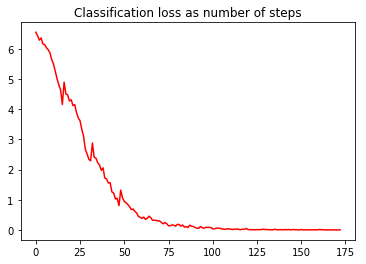

In [11]:
plot.title('Classification loss as number of steps')
plot.plot(loss_step, loss1_val, 'r')
plot.show()

## Classification accuracy

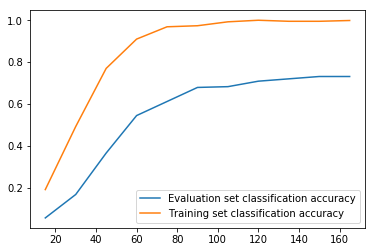

In [13]:
plot.plot(evaluation_step, acc_val, label='Evaluation set classification accuracy')
plot.plot(evaluation_step, acc_train, label='Training set classification accuracy')
plot.legend()
plot.show()

## Training using similarity loss, similarity threshold set to 5

In [7]:
num_of_ids = len(subject_list)
loss1_val = []
loss2_val = []
loss_step = []
acc_val = []
sim_val = []
acc_train = []
sim_train = []
evaluation_step = []
STEP_SIZE_LOSS = 10
STEP_SIZE_EVALUATE = 40

batch_size = 1000
num_of_epochs = 200
dataset = Dataset(data_dict['X_train'], data_dict['y_train'], batch_size, num_of_epochs)
with tf.device("/device:GPU:0"):
    model = CombinedClassifier(num_of_ids=num_of_ids, loss_type="Similarity", similarity_threshold=5)
    model.load_weights('cpt/cpt_150')
    
    for step in range(dataset.steps):
        batch_x, batch_y = dataset.create_mini_batch()
        if (step % STEP_SIZE_EVALUATE == 0 and step != 0):          
            # Evaluate on validation set
            accuracy, sim = model.test(data_dict['X_eval'], data_dict['y_eval'], similarity_test=True)
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "EVAL SET: Step %d: similarity accuracy: %f" % (step, sim)))
            acc_val.append(accuracy)
            sim_val.append(sim)
            evaluation_step.append(step)
            
            # Evaluate on training set
            accuracy, sim = model.test(batch_x, batch_y, similarity_test=True, training_set=True)
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "TRAIN SET: Step %d: similarity accuracy: %f" % (step, sim)))
            acc_train.append(accuracy)
            sim_train.append(sim)
            
        
        loss1, loss2 = model.optimize(batch_x, batch_y)
        loss1_val.append(loss1)
        loss2_val.append(loss2)
        loss_step.append(step)
        
        if (step % STEP_SIZE_LOSS == 0):
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "Step %d: Similartiy loss: %f" % (step, loss2)))


[14.10|14:08:29] Step 0: Similartiy loss: 1.932382
[14.10|14:08:35] Step 10: Similartiy loss: 1.741730
[14.10|14:08:41] Step 20: Similartiy loss: 1.416564
[14.10|14:08:47] Step 30: Similartiy loss: 1.280466
[14.10|14:08:53] EVAL SET: Step 40: similarity accuracy: 0.716418
[14.10|14:08:53] TRAIN SET: Step 40: similarity accuracy: 0.862000
[14.10|14:08:53] Step 40: Similartiy loss: 1.249892
[14.10|14:08:59] Step 50: Similartiy loss: 1.219680
[14.10|14:09:05] Step 60: Similartiy loss: 1.241323
[14.10|14:09:11] Step 70: Similartiy loss: 1.044822
[14.10|14:09:17] EVAL SET: Step 80: similarity accuracy: 0.761194
[14.10|14:09:18] TRAIN SET: Step 80: similarity accuracy: 0.936000
[14.10|14:09:18] Step 80: Similartiy loss: 0.904313
[14.10|14:09:24] Step 90: Similartiy loss: 1.037354
[14.10|14:09:30] Step 100: Similartiy loss: 1.072457
[14.10|14:09:36] Step 110: Similartiy loss: 1.017895
[14.10|14:09:41] EVAL SET: Step 120: similarity accuracy: 0.761194
[14.10|14:09:42] TRAIN SET: Step 120: simi

[14.10|14:18:16] TRAIN SET: Step 960: similarity accuracy: 0.920000
[14.10|14:18:17] Step 960: Similartiy loss: 0.564280
[14.10|14:18:23] Step 970: Similartiy loss: 0.265106
[14.10|14:18:28] Step 980: Similartiy loss: 0.319502
[14.10|14:18:34] Step 990: Similartiy loss: 0.372695
[14.10|14:18:40] EVAL SET: Step 1000: similarity accuracy: 0.828358
[14.10|14:18:41] TRAIN SET: Step 1000: similarity accuracy: 0.992000
[14.10|14:18:41] Step 1000: Similartiy loss: 0.389939
[14.10|14:18:47] Step 1010: Similartiy loss: 0.441420
[14.10|14:18:53] Step 1020: Similartiy loss: 0.539713
[14.10|14:18:59] Step 1030: Similartiy loss: 0.268749
[14.10|14:19:05] EVAL SET: Step 1040: similarity accuracy: 0.835821
[14.10|14:19:05] TRAIN SET: Step 1040: similarity accuracy: 0.990000
[14.10|14:19:06] Step 1040: Similartiy loss: 0.307119
[14.10|14:19:11] Step 1050: Similartiy loss: 0.311544
[14.10|14:19:17] Step 1060: Similartiy loss: 0.430949
[14.10|14:19:23] Step 1070: Similartiy loss: 0.449079
[14.10|14:19:2

## Similarity Loss 

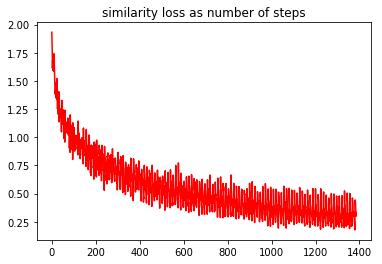

In [8]:
plot.title('similarity loss as number of steps')
plot.plot(loss_step, loss2_val, 'r')
plot.show()

## Evaluation for similarity check

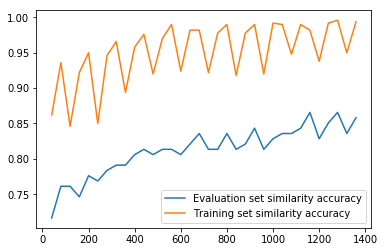

In [9]:
plot.plot(evaluation_step, sim_val, label='Evaluation set similarity accuracy')
plot.plot(evaluation_step, sim_train, label='Training set similarity accuracy')
plot.legend()
plot.show()

In [10]:
model.save_weights('cpt/cpt_final_5')

## Training using similarity loss, similarity threshold set to 10

In [7]:
num_of_ids = len(subject_list)
loss1_val = []
loss2_val = []
loss_step = []
acc_val = []
sim_val = []
acc_train = []
sim_train = []
evaluation_step = []
STEP_SIZE_LOSS = 10
STEP_SIZE_EVALUATE = 40

batch_size = 1000
num_of_epochs = 200
dataset = Dataset(data_dict['X_train'], data_dict['y_train'], batch_size, num_of_epochs)
with tf.device("/device:GPU:0"):
    model = CombinedClassifier(num_of_ids=num_of_ids, loss_type="Similarity", similarity_threshold=10)
    model.load_weights('cpt/cpt_150')
    
    for step in range(dataset.steps):
        batch_x, batch_y = dataset.create_mini_batch()
        if (step % STEP_SIZE_EVALUATE == 0 and step != 0):          
            # Evaluate on validation set
            accuracy, sim = model.test(data_dict['X_eval'], data_dict['y_eval'], similarity_test=True)
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "EVAL SET: Step %d: similarity accuracy: %f" % (step, sim)))
            acc_val.append(accuracy)
            sim_val.append(sim)
            evaluation_step.append(step)
            
            # Evaluate on training set
            accuracy, sim = model.test(batch_x, batch_y, similarity_test=True, training_set=True)
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "TRAIN SET: Step %d: similarity accuracy: %f" % (step, sim)))
            acc_train.append(accuracy)
            sim_train.append(sim)
            
        
        loss1, loss2 = model.optimize(batch_x, batch_y)
        loss1_val.append(loss1)
        loss2_val.append(loss2)
        loss_step.append(step)
        
        if (step % STEP_SIZE_LOSS == 0):
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "Step %d: similartiy loss: %f" % (step, loss2)))


[14.10|13:18:49] Step 0: Similartiy loss: 4.496734
[14.10|13:18:55] Step 10: Similartiy loss: 3.254667
[14.10|13:19:00] Step 20: Similartiy loss: 2.827345
[14.10|13:19:06] Step 30: Similartiy loss: 2.957618
[14.10|13:19:12] EVAL SET: Step 40: similarity accuracy: 0.731343
[14.10|13:19:13] TRAIN SET: Step 40: similarity accuracy: 0.846000
[14.10|13:19:13] Step 40: Similartiy loss: 2.489417
[14.10|13:19:19] Step 50: Similartiy loss: 2.300358
[14.10|13:19:25] Step 60: Similartiy loss: 2.592091
[14.10|13:19:31] Step 70: Similartiy loss: 2.168775
[14.10|13:19:37] EVAL SET: Step 80: similarity accuracy: 0.746269
[14.10|13:19:37] TRAIN SET: Step 80: similarity accuracy: 0.920000
[14.10|13:19:37] Step 80: Similartiy loss: 2.046443
[14.10|13:19:43] Step 90: Similartiy loss: 2.100908
[14.10|13:19:49] Step 100: Similartiy loss: 2.180615
[14.10|13:19:55] Step 110: Similartiy loss: 2.150287
[14.10|13:20:01] EVAL SET: Step 120: similarity accuracy: 0.761194
[14.10|13:20:02] TRAIN SET: Step 120: simi

[14.10|13:28:36] TRAIN SET: Step 960: similarity accuracy: 0.926000
[14.10|13:28:36] Step 960: Similartiy loss: 1.256815
[14.10|13:28:42] Step 970: Similartiy loss: 0.541983
[14.10|13:28:48] Step 980: Similartiy loss: 0.735405
[14.10|13:28:54] Step 990: Similartiy loss: 0.919560
[14.10|13:29:00] EVAL SET: Step 1000: similarity accuracy: 0.828358
[14.10|13:29:01] TRAIN SET: Step 1000: similarity accuracy: 0.972000
[14.10|13:29:01] Step 1000: Similartiy loss: 0.914891
[14.10|13:29:07] Step 1010: Similartiy loss: 1.049098
[14.10|13:29:13] Step 1020: Similartiy loss: 1.056723
[14.10|13:29:19] Step 1030: Similartiy loss: 0.588504
[14.10|13:29:25] EVAL SET: Step 1040: similarity accuracy: 0.835821
[14.10|13:29:25] TRAIN SET: Step 1040: similarity accuracy: 0.984000
[14.10|13:29:25] Step 1040: Similartiy loss: 0.739638
[14.10|13:29:31] Step 1050: Similartiy loss: 0.632947
[14.10|13:29:37] Step 1060: Similartiy loss: 0.757869
[14.10|13:29:43] Step 1070: Similartiy loss: 0.994553
[14.10|13:29:4

## Similarity Loss 

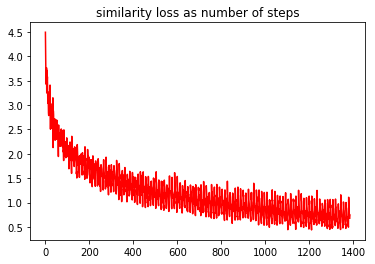

In [8]:
plot.title('similarity loss as number of steps')
plot.plot(loss_step, loss2_val, 'r')
plot.show()

## Evaluation for similarity check

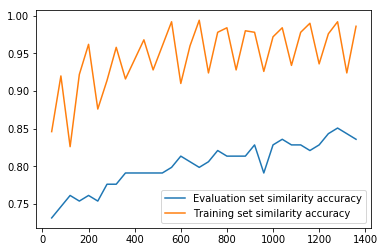

In [9]:
plot.plot(evaluation_step, sim_val, label='Evaluation set similarity accuracy')
plot.plot(evaluation_step, sim_train, label='Training set similarity accuracy')
plot.legend()
plot.show()

In [10]:
model.save_weights('cpt/cpt_final')

## Training using similarity loss, similarity threshold set to 20

In [7]:
num_of_ids = len(subject_list)
loss1_val = []
loss2_val = []
loss_step = []
acc_val = []
sim_val = []
acc_train = []
sim_train = []
evaluation_step = []
STEP_SIZE_LOSS = 10
STEP_SIZE_EVALUATE = 40

batch_size = 1000
num_of_epochs = 150
dataset = Dataset(data_dict['X_train'], data_dict['y_train'], batch_size, num_of_epochs)
with tf.device("/device:GPU:0"):
    model = CombinedClassifier(num_of_ids=num_of_ids, loss_type="Similarity", similarity_threshold=20)
    model.load_weights('cpt/cpt_150')
    
    for step in range(dataset.steps):
        batch_x, batch_y = dataset.create_mini_batch()
        if (step % STEP_SIZE_EVALUATE == 0 and step != 0):          
            # Evaluate on validation set
            accuracy, sim = model.test(data_dict['X_eval'], data_dict['y_eval'], similarity_test=True)
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "EVAL SET: Step %d: similarity accuracy: %f" % (step, sim)))
            acc_val.append(accuracy)
            sim_val.append(sim)
            evaluation_step.append(step)
            
            # Evaluate on training set
            accuracy, sim = model.test(batch_x, batch_y, similarity_test=True, training_set=True)
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "TRAIN SET: Step %d: similarity accuracy: %f" % (step, sim)))
            acc_train.append(accuracy)
            sim_train.append(sim)
            
        
        loss1, loss2 = model.optimize(batch_x, batch_y)
        loss1_val.append(loss1)
        loss2_val.append(loss2)
        loss_step.append(step)
        
        if (step % STEP_SIZE_LOSS == 0):
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "Step %d: Similartiy loss: %f" % (step, loss2)))


[14.10|14:44:37] Step 0: Similartiy loss: 9.399091
[14.10|14:44:43] Step 10: Similartiy loss: 8.229424
[14.10|14:44:49] Step 20: Similartiy loss: 5.421539
[14.10|14:44:54] Step 30: Similartiy loss: 6.086620
[14.10|14:45:01] EVAL SET: Step 40: similarity accuracy: 0.701493
[14.10|14:45:01] TRAIN SET: Step 40: similarity accuracy: 0.846000
[14.10|14:45:01] Step 40: Similartiy loss: 5.112363
[14.10|14:45:07] Step 50: Similartiy loss: 5.111140
[14.10|14:45:13] Step 60: Similartiy loss: 4.956662
[14.10|14:45:19] Step 70: Similartiy loss: 4.443929
[14.10|14:45:25] EVAL SET: Step 80: similarity accuracy: 0.708955
[14.10|14:45:25] TRAIN SET: Step 80: similarity accuracy: 0.864000
[14.10|14:45:26] Step 80: Similartiy loss: 5.691291
[14.10|14:45:32] Step 90: Similartiy loss: 4.305124
[14.10|14:45:37] Step 100: Similartiy loss: 5.205498
[14.10|14:45:43] Step 110: Similartiy loss: 4.597186
[14.10|14:45:49] EVAL SET: Step 120: similarity accuracy: 0.723881
[14.10|14:45:50] TRAIN SET: Step 120: simi

[14.10|14:54:25] Step 960: Similartiy loss: 2.624721
[14.10|14:54:31] Step 970: Similartiy loss: 1.512719
[14.10|14:54:37] Step 980: Similartiy loss: 1.799444
[14.10|14:54:43] Step 990: Similartiy loss: 2.079094
[14.10|14:54:49] EVAL SET: Step 1000: similarity accuracy: 0.805970
[14.10|14:54:50] TRAIN SET: Step 1000: similarity accuracy: 0.974000
[14.10|14:54:50] Step 1000: Similartiy loss: 2.207618
[14.10|14:54:56] Step 1010: Similartiy loss: 2.120213
[14.10|14:55:02] Step 1020: Similartiy loss: 2.804858
[14.10|14:55:08] Step 1030: Similartiy loss: 1.507803


## Similarity Loss 

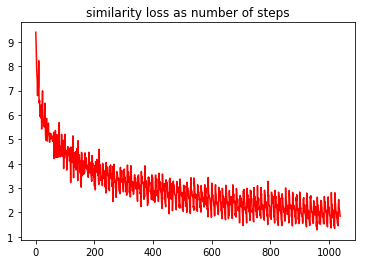

In [8]:
plot.title('similarity loss as number of steps')
plot.plot(loss_step, loss2_val, 'r')
plot.show()

# Evaluation fo similarity check

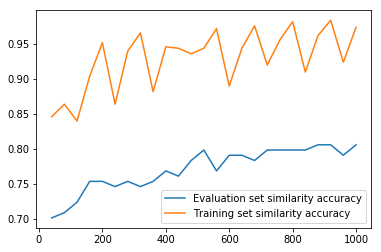

In [9]:
plot.plot(evaluation_step, sim_val, label='Evaluation set similarity accuracy')
plot.plot(evaluation_step, sim_train, label='Training set similarity accuracy')
plot.legend()
plot.show()

In [10]:
model.save_weights('cpt/cpt_final_20')